## Class Tutorial

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle 
from astropy.io import fits
%matplotlib widget

We use a class to define several functions in a self-consistent way repeatedly and be able to use them in different notebooks without rewriting them.

### Class Objects
Class objects support two kind of operations: *attribute references* and *instantiation*. **Attribute references** use the standard syntax in python (obj.name).

In [34]:
# Example:
class MyClass:
    """A simple example class"""
    internal_variable = 12345

    def print_hello(self):
        return 'Hello World'

# To retrieve the value of the internal variable we use:
print(MyClass.internal_variable)
# To use the function of the class we use
MyClass.print_hello(MyClass)

12345


'Hello World'

The argument $\texttt{self}$ of the class means that the function requires the class itself as an argument.

**Class instantiation** uses function notation. We can create a new instance of the class and assign his object to a local variable.

In [35]:
first_class = MyClass()
second_class = MyClass()
# We have two objects of type MyClass with all the attributes and functions
# of the original class but will work independently

second_class.internal_variable = 67890
print('first_class internal variable value:', first_class.internal_variable)
print('second_class internal variable value:', second_class.internal_variable)

first_class internal variable value: 12345
second_class internal variable value: 67890


A variable inside a class takes the name of **attribute** while functions are called **methods**. When calling a method of an instance object you don0t need to specify the self argument

In [36]:
MyClass.print_hello(MyClass) #Here I need the self argument
second_class.print_hello() #Here I don't need it, notice the difference

'Hello World'

### Class Initialization
Classes support a special kind of method that is automatically called **every time** you create a new class instance. This inizialization method is defined by the name ```__init__```. When we create a new object using our class, the init method is automatically invoked. In the following example init requires two arguments other than the self one, so we have to provide them to avoid an error 

In [37]:
class MySecondClass:
    def __init__(self, x_input, y_input):
        self.x_pos = x_input
        self.y_pos = y_input

#new_class = MySecondClass() -> WRONG! No arguments
new_class = MySecondClass(258, 76) # Correct

If we change the class, we have to make a new instance, the previous one won't be updated.

In [38]:
class MySecondClass:
    def __init__(self, x_input, y_input):
        self.x_pos = x_input
        self.y_pos = y_input

    def print_position(self):
        print('Attributes called from a class method', self.x_pos, self.y_pos)

    def change_position(self, x_new, y_new):
        self.x_pos = x_new
        self.y_pos = y_new

newest_class = MySecondClass(260, 76)
newest_class.print_position()

print('attributes called from instance object:', new_class.x_pos, new_class.y_pos)

Attributes called from a class method 260 76
attributes called from instance object: 258 76


We can write a method to change one or more attributes. The method must get ```self``` as the argument, and the attributes to be changed must be referenced as ```self```

In [39]:
class MySecondClass:

    def change_position(self, x_new, y_new):
        self.x_pos = x_new
        self.y_pos = y_new

    """def wrong_method(x_new, y_new):
        x_pos = x_new
        y_pos = y_new"""
    
    """All the methods called after the change_position will use the updated
    values for self.x_pos and self.y_pos"""

new_class = MySecondClass()
new_class.change_position(789, 123)
print(new_class.x_pos, new_class.y_pos)

789 123


## Aperture Photometry Class
Let's make our class to perform aperture photometry with different apertures and on several stars effortlessly. The complete code will be exported in a .py file for further use.

### Initialization
As this is a work in progress, we will call our class ```TemporaryAperturePhotometry``` for now. We provide some constants that will be the same regardless of the star under analysis (given that we use the same frames).


In [40]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

target_star = TemporaryAperturePhotometry()
print(target_star.science_list[:10])

['AF559481.fits' 'AF559482.fits' 'AF559483.fits' 'AF559484.fits'
 'AF559485.fits' 'AF559486.fits' 'AF559487.fits' 'AF559488.fits'
 'AF559489.fits' 'AF559490.fits']


Since the calibration files (bias, flat) and the science files have the same size, we can define here the meshgrid arrays used later on to compute the distance of each pixel from our star.

In [41]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

target_star = TemporaryAperturePhotometry()
#Check del funzionamento
#print(target_star.X, target_star.Y) # Funziona
#print(target_star.median_bias_error_distribution, target_star.median_bias_error_value) # Funziona


### Defining the ```aperture_photometry``` method
We start with an empty function and we slowly fill it with all the operations we have done during the previous lectures, starting from ```03 - Science Analysis.ipynb```

In [42]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def aperture_photometry(self):
        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)
            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()


#### Extracting information from the header
Since we are opening our science fits file, this is the moment to retrieve and store all the information we need from the header.
1. Outside the cycle we create an empty array with size equal to the number of frames for each information we have to store
2. Inside the cycle we have to populate thos arrays. We have to read the header before closing the fits file and we have to store the information as class *attributes* in order to be able to use them in other functions.

In [43]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def aperture_photometry(self):


        # Array Initialization
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)


        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)

            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']

            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()

Now that we have all the information we need, we define a method called ```correct_science_frame``` which corrects the raw science frame in input and gives the corrected science frame and the associated errors in output. Then we use this method inside the ```aperture_photometry``` method.

In [44]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def correct_science_frame(self, science_data):
        """ 
        This function corrects a single science frame by subtracting the bias and
        dividing by the flat.

        Inputs:
        - self: median_bias, median_normalized_flat, readout_noise, bias_std, median_normalized_flat_error, median_normalized_flat.
        - science_data: 2D array containing the flux of each pixel of the selected frame.

        Returns:
        - science_corrected: 2D array containing the flux of each pixel of the corrected science frame.
        - science_corrected_error: 2D array containing the error on each pixel of the corrected frame.
        """
        # Correct the frame by subtracting bias and dividing by flat
        science_debiased = science_data - self.median_bias
        science_corrected = science_debiased /self.median_normalized_flat

        # Compute the error on the corrected frame
        science_debiased_error = np.sqrt(self.readout_noise**2 + self.bias_std**2 + science_debiased)
        science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)

        return science_corrected, science_corrected_error

    def aperture_photometry(self):


        # Array Initialization
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)


        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)

            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']

            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()

            # Call the method to correct the frame for bias and flat.
            science_corrected, science_corrected_error = self.correct_science_frame(science_data)


#### Defining sky correction and aperture photometry

Before computing the centroid and performing the aperture photometry, we need to provide:
1. Sky inner and outer radius to define the annulus for the measurement of the background.
2. Aperture_radius for the aperture photometry
3. Initial guess for the position of the star, x_initial and y_initial

We will define those parameters inside the aperture photometry method.

Next we have to incorporate the **Centroid Algorithm**.
- We take the algorithm we used in ```04 - Centroid Measurement``` to compute the centroid position and encapsulate it inside a new method
- Provide the necessary parameters (science frame, maximum number of iterations, ...)
- Return the refined coordinates of the centre.

In [45]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def correct_science_frame(self, science_data):
        """ 
        This function corrects a single science frame by subtracting the bias and
        dividing by the flat.

        Inputs:
        - self: median_bias, median_normalized_flat, readout_noise, bias_std, median_normalized_flat_error, median_normalized_flat.
        - science_data: 2D array containing the flux of each pixel of the selected frame.

        Returns:
        - science_corrected: 2D array containing the flux of each pixel of the corrected science frame.
        - science_corrected_error: 2D array containing the error on each pixel of the corrected frame.
        """

        # Correct the frame by subtracting bias and dividing by flat
        science_debiased = science_data - self.median_bias
        science_corrected = science_debiased /self.median_normalized_flat

        # Compute the error on the corrected frame
        science_debiased_error = np.sqrt(self.readout_noise**2 + self.bias_std**2 + science_debiased)
        science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)

        return science_corrected, science_corrected_error

    def compute_centroid(self, science_frame, x_target_initial, y_target_initial, max_iterations=20):
        """       
        This function computes the coordinates of the centroid of a selected frame.

        Inputs:
        - self: attributes of the class.
        - science_frame: frame on which to compute the centroid. It should be a science corrected frame.
        - x_target_initial: initial estimate of the x coordinate of the centroid.
        - y_target_initial: initial estimate of the y coordinate of the centroid.
        - max_iterations: number of iterations for the centroid algorithm (default=20).

        Returns:
        - x_target_refined: refined x coordinate of the centroid.
        - y_target_refined: refined y coordinate of the centroid.
        """
        
        for i in range(0, max_iterations):

            if i == 0: # First iteration
                x_target_previous = x_target_initial
                y_target_previous = y_target_initial
            else: # Use the previous iteration results as new starting point
                x_target_previous = x_target_refined
                y_target_previous = y_target_refined
            
            # 2D Array with the distance of each pixel from the target star
            target_distance = np.sqrt((self.X-x_target_previous)**2 + (self.Y-y_target_previous)**2)

            # Creation of the annulus as a 2D boolean array
            annulus_selection = (target_distance < self.sky_inner_radius)

            # Weighted sum of coordinates
            weighted_X = np.sum(science_frame[annulus_selection]*self.X[annulus_selection])
            weighted_Y = np.sum(science_frame[annulus_selection]*self.Y[annulus_selection])

            # Sum of the weights
            total_flux = np.sum(science_frame[annulus_selection])

            # Refined determination of coordinates
            x_target_refined = weighted_X / total_flux
            y_target_refined = weighted_Y / total_flux

            precent_variance_x = (x_target_refined - x_target_previous)/(x_target_previous)*100
            percent_variance_y = (y_target_refined - y_target_previous)/(y_target_previous)*100

            if np.abs(precent_variance_x)<0.1 and np.abs(percent_variance_y)<0.1:
                break
        
        return x_target_refined, y_target_refined


    def aperture_photometry(self, sky_inner_radius, sky_outer_radius, aperture_radius, x_initial, y_initial):

        # Aperture Photometry Parameters
        self.sky_inner_radius = sky_inner_radius
        self.sky_outer_radius = sky_outer_radius
        self.aperture_radius = aperture_radius
        self.x_initial = x_initial
        self.y_initial = y_initial

        # Array Initialization for HEADER Parameters
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)


        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)

            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']

            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()

            # Call the method to correct the frame for bias and flat.
            science_corrected, science_corrected_error = self.correct_science_frame(science_data)

            # Call the method to compute the centroid coordinates
            x_target_refined, y_target_refined = self.compute_centroid(science_corrected, x_initial, y_initial)
            # print(x_target_refined, y_target_refined)

# Per verificarne il funzionamento, rimuovere i commenti sotto e al print sopra
# my_class = TemporaryAperturePhotometry()
# my_class.aperture_photometry(13, 19.5, 6, 228, 33)


#### Computing the sky background

The last method we need is a function that computes the sky background following the same steps seen in ```05 - Aperture Photometry```

In [46]:
class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def correct_science_frame(self, science_data):
        """ 
        This function corrects a single science frame by subtracting the bias and
        dividing by the flat.

        Inputs:
        - self: median_bias, median_normalized_flat, readout_noise, bias_std, median_normalized_flat_error, median_normalized_flat.
        - science_data: 2D array containing the flux of each pixel of the selected frame.

        Returns:
        - science_corrected: 2D array containing the flux of each pixel of the corrected science frame.
        - science_corrected_error: 2D array containing the error on each pixel of the corrected frame.
        """

        # Correct the frame by subtracting bias and dividing by flat
        science_debiased = science_data - self.median_bias
        science_corrected = science_debiased /self.median_normalized_flat

        # Compute the error on the corrected frame
        science_debiased_error = np.sqrt(self.readout_noise**2 + self.bias_std**2 + science_debiased)
        science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)

        return science_corrected, science_corrected_error

    def compute_centroid(self, science_frame, x_target_initial, y_target_initial, max_iterations=20):
        """       
        This function computes the coordinates of the centroid of a selected frame.

        Inputs:
        - self: attributes of the class.
        - science_frame: frame on which to compute the centroid. It should be a science corrected frame.
        - x_target_initial: initial estimate of the x coordinate of the centroid.
        - y_target_initial: initial estimate of the y coordinate of the centroid.
        - max_iterations: number of iterations for the centroid algorithm (default=20).

        Returns:
        - x_target_refined: refined x coordinate of the centroid.
        - y_target_refined: refined y coordinate of the centroid.
        """
        
        for i in range(0, max_iterations):

            if i == 0: # First iteration
                x_target_previous = x_target_initial
                y_target_previous = y_target_initial
            else: # Use the previous iteration results as new starting point
                x_target_previous = x_target_refined
                y_target_previous = y_target_refined
            
            # 2D Array with the distance of each pixel from the target star
            target_distance = np.sqrt((self.X-x_target_previous)**2 + (self.Y-y_target_previous)**2)

            # Creation of the annulus as a 2D boolean array
            annulus_selection = (target_distance < self.sky_inner_radius)

            # Weighted sum of coordinates
            weighted_X = np.sum(science_frame[annulus_selection]*self.X[annulus_selection])
            weighted_Y = np.sum(science_frame[annulus_selection]*self.Y[annulus_selection])

            # Sum of the weights
            total_flux = np.sum(science_frame[annulus_selection])

            # Refined determination of coordinates
            x_target_refined = weighted_X / total_flux
            y_target_refined = weighted_Y / total_flux

            precent_variance_x = (x_target_refined - x_target_previous)/(x_target_previous)*100
            percent_variance_y = (y_target_refined - y_target_previous)/(y_target_previous)*100

            if np.abs(precent_variance_x)<0.1 and np.abs(percent_variance_y)<0.1:
                break
        
        return x_target_refined, y_target_refined

    def compute_sky_background(self, science_frame, x_target, y_target):
        """      
        This function computes the sky background contribution to the total flux around a certain target.

        Inputs:
        - self: attributes of the class.
        - science_frame: the science frame, already corrected for bias and flat.
        - x_target: x coordinate of the center around which to compute the sky background.
        - y_target: y coordinate of the center around which to compute the sky background.
        
        Returns:
        - sky_flux_median: a single value containing the median sky background flux.
        - sky_flux_median_error: a single value containing the error on the median sky background flux.
        """

        # Compute distance of each pixel from the target
        target_distance = np.sqrt((self.X-x_target)**2 + (self.Y-y_target)**2)

        # Select the annulus region just outside of the star
        annulus_selection = (target_distance > self.sky_inner_radius) & (target_distance <= self.sky_outer_radius)

        # Compute the average and median flux inside the annulus
        sky_flux_average = np.sum(science_frame[annulus_selection]) / np.sum(annulus_selection)
        sky_flux_median = np.median(science_frame[annulus_selection])

        # Compute the error on the average and median flux
        sky_flux_average_error = np.std(science_frame[annulus_selection])/np.sqrt(len(science_frame[annulus_selection]))
        sky_flux_median_error = sky_flux_average_error * 1.253
    
        return sky_flux_median, sky_flux_median_error

    def aperture_photometry(self, sky_inner_radius, sky_outer_radius, aperture_radius, x_initial, y_initial):

        # Aperture Photometry Parameters
        self.sky_inner_radius = sky_inner_radius
        self.sky_outer_radius = sky_outer_radius
        self.aperture_radius = aperture_radius
        self.x_initial = x_initial
        self.y_initial = y_initial

        # Array Initialization for HEADER Parameters
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)

        # Array Initialization for results
        self.aperture = np.empty(self.science_size)
        self.aperture_error = np.empty(self.science_size)
        self.sky_background = np.empty(self.science_size)
        self.sky_background_error = np.empty(self.science_size)
        self.x_position = np.empty(self.science_size)
        self.y_position = np.empty(self.science_size)


        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)

            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']

            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()

            # Call the method to correct the frame for bias and flat.
            science_corrected, science_corrected_error = self.correct_science_frame(science_data)

            # Call the method to compute the centroid coordinates
            x_target_refined, y_target_refined = self.compute_centroid(science_corrected, x_initial, y_initial)

            # Call the method to compute the sky background flux and error.
            sky_flux_median, sky_flux_median_error = self.compute_sky_background(science_corrected, x_target_refined, y_target_refined)

            # Correct the frames subtracting the sky background and compute the error.
            science_sky_corrected = science_corrected - sky_flux_median
            science_sky_corrected_error = np.sqrt(science_corrected_error**2 + sky_flux_median_error**2)

            # Perform aperture photometry
            target_distance = np.sqrt((self.X-x_target_refined)**2 + (self.Y-y_target_refined)**2)
            aperture_selection = (target_distance < self.aperture_radius)
            aperture_photometry = np.sum(science_sky_corrected[aperture_selection])
            aperture_photometry_error = np.sqrt(np.sum((science_sky_corrected_error[aperture_selection])**2))

            # Save the results inside attributes
            self.aperture[i] = aperture_photometry
            self.aperture_error[i] = aperture_photometry_error
            self.sky_background[i] = science_sky_corrected
            self.sky_background_error[i] = science_sky_corrected_error
            self.x_position[i] = x_target_refined
            self.y_position[i] = y_target_refined



### Test the class
Now we see how to obtain the aperture photometry for our target star and one reference star that we will use later on to compute the differential photometry. Before that we need to compute the correct BJD_TDB format. We will use the algorithm presented in ```03 - Science Analysis.ipynb``` and do it in the ```aperture_photometry``` method right after extracting the JD from the header.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle 
from astropy.io import fits
from astropy import coordinates as coord
from astropy import units as u
from astropy.time import Time


class TemporaryAperturePhotometry:
    def __init__(self):
        
        self.data_path = './group10_WASP-135_20190803/'

        # Constants from HEADER file
        self.readout_noise = 7.10 # [e] photoelectrons
        self.gain = 1.91 # [e] photoelectrons

        # Computed in 01 - Bias Analysis.ipynb
        self.bias_std = 1.33 # [e] = photoelectrons
        self.median_bias = pickle.load(open('./median_bias.p', 'rb'))
        self.median_bias_error_distribution = pickle.load(open('./median_bias_error.p', 'rb'))
        # We chose to use the specific value in lecture 01
        self.median_bias_error_value = pickle.load(open('./median_bias_error_value.p', 'rb'))

        # Computed in 02 - Flat Analysis.ipynb
        self.median_normalized_flat = pickle.load(open('./median_normalized_flat.p', 'rb'))
        self.median_normalized_flat_error = pickle.load(open('./median_normalized_flat_errors.p', 'rb'))

        # Computed in 03 - Science Analysis.ipynb
        self.science_path = self.data_path + 'science/'
        self.science_list = np.genfromtxt(self.science_path + 'science.list', dtype = str)
        self.science_size = len(self.science_list)

        # Meshgrid Definition (remember to swap x and y)
        ylen, xlen = np.shape(self.median_bias)
        X_axis = np.arange(0, xlen, 1)
        Y_axis = np.arange(0, ylen, 1)
        # Only the meshgrid arrays are stored as attributes, we don't need the intermediate steps
        self.X, self.Y = np.meshgrid(X_axis, Y_axis)

    def correct_science_frame(self, science_data):
        """ 
        This function corrects a single science frame by subtracting the bias and
        dividing by the flat.

        Inputs:
        - self: median_bias, median_normalized_flat, readout_noise, bias_std, median_normalized_flat_error, median_normalized_flat.
        - science_data: 2D array containing the flux of each pixel of the selected frame.

        Returns:
        - science_corrected: 2D array containing the flux of each pixel of the corrected science frame.
        - science_corrected_error: 2D array containing the error on each pixel of the corrected frame.
        """

        # Correct the frame by subtracting bias and dividing by flat
        science_debiased = science_data - self.median_bias
        science_corrected = science_debiased /self.median_normalized_flat

        # Compute the error on the corrected frame
        science_debiased_error = np.sqrt(self.readout_noise**2 + self.bias_std**2 + science_debiased)
        science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)

        return science_corrected, science_corrected_error

    def compute_centroid(self, science_frame, x_target_initial, y_target_initial, max_iterations=20):
        """       
        This function computes the coordinates of the centroid of a selected frame.

        Inputs:
        - self: attributes of the class.
        - science_frame: frame on which to compute the centroid. It should be a science corrected frame.
        - x_target_initial: initial estimate of the x coordinate of the centroid.
        - y_target_initial: initial estimate of the y coordinate of the centroid.
        - max_iterations: number of iterations for the centroid algorithm (default=20).

        Returns:
        - x_target_refined: refined x coordinate of the centroid.
        - y_target_refined: refined y coordinate of the centroid.
        """
        
        for i in range(0, max_iterations):

            if i == 0: # First iteration
                x_target_previous = x_target_initial
                y_target_previous = y_target_initial
            else: # Use the previous iteration results as new starting point
                x_target_previous = x_target_refined
                y_target_previous = y_target_refined
            
            # 2D Array with the distance of each pixel from the target star
            target_distance = np.sqrt((self.X-x_target_previous)**2 + (self.Y-y_target_previous)**2)

            # Creation of the annulus as a 2D boolean array
            annulus_selection = (target_distance < self.sky_inner_radius)

            # Weighted sum of coordinates
            weighted_X = np.sum(science_frame[annulus_selection]*self.X[annulus_selection])
            weighted_Y = np.sum(science_frame[annulus_selection]*self.Y[annulus_selection])

            # Sum of the weights
            total_flux = np.sum(science_frame[annulus_selection])

            # Refined determination of coordinates
            x_target_refined = weighted_X / total_flux
            y_target_refined = weighted_Y / total_flux

            precent_variance_x = (x_target_refined - x_target_previous)/(x_target_previous)*100
            percent_variance_y = (y_target_refined - y_target_previous)/(y_target_previous)*100

            if np.abs(precent_variance_x)<0.1 and np.abs(percent_variance_y)<0.1:
                break
        
        return x_target_refined, y_target_refined

    def compute_sky_background(self, science_frame, x_target, y_target):
        """      
        This function computes the sky background contribution to the total flux around a certain target.

        Inputs:
        - self: attributes of the class.
        - science_frame: the science frame, already corrected for bias and flat.
        - x_target: x coordinate of the center around which to compute the sky background.
        - y_target: y coordinate of the center around which to compute the sky background.
        
        Returns:
        - sky_flux_median: a single value containing the median sky background flux.
        - sky_flux_median_error: a single value containing the error on the median sky background flux.
        """

        # Compute distance of each pixel from the target
        target_distance = np.sqrt((self.X-x_target)**2 + (self.Y-y_target)**2)

        # Select the annulus region just outside of the star
        annulus_selection = (target_distance > self.sky_inner_radius) & (target_distance <= self.sky_outer_radius)

        # Compute the average and median flux inside the annulus
        sky_flux_average = np.sum(science_frame[annulus_selection]) / np.sum(annulus_selection)
        sky_flux_median = np.median(science_frame[annulus_selection])

        # Compute the error on the average and median flux
        sky_flux_average_error = np.std(science_frame[annulus_selection])/np.sqrt(len(science_frame[annulus_selection]))
        sky_flux_median_error = sky_flux_average_error * 1.253
    
        return sky_flux_median, sky_flux_median_error

    def aperture_photometry(self, sky_inner_radius, sky_outer_radius, aperture_radius, x_initial, y_initial):

        # Aperture Photometry Parameters
        self.sky_inner_radius = sky_inner_radius
        self.sky_outer_radius = sky_outer_radius
        self.aperture_radius = aperture_radius
        self.x_initial = x_initial
        self.y_initial = y_initial

        # Array Initialization for HEADER Parameters
        self.airmass = np.empty(self.science_size)
        self.exptime = np.empty(self.science_size)
        self.julian_date = np.empty(self.science_size)
        
        # Array Initialization for results
        self.aperture = np.empty(self.science_size)
        self.aperture_error = np.empty(self.science_size)
        self.sky_background = np.empty(self.science_size)
        self.sky_background_error = np.empty(self.science_size)
        self.x_position = np.empty(self.science_size)
        self.y_position = np.empty(self.science_size)
        self.bjd_tdb = np.empty(self.science_size)



        for i, science_name in enumerate(self.science_list):
            # Open the i-th fits file
            science_fits = fits.open(self.science_path +  science_name)

            self.airmass[i] = science_fits[0].header['AIRMASS']
            self.exptime[i] = science_fits[0].header['EXPTIME']
            self.julian_date[i] = science_fits[0].header['JD']

            # Save the i-th flux in science_data
            science_data = science_fits[0].data * self.gain # Viene sovrascritto ad ogni iterazione quindi va salvato prima della fine del ciclo
            science_fits.close()

            # Call the method to correct the frame for bias and flat.
            science_corrected, science_corrected_error = self.correct_science_frame(science_data)

            # Call the method to compute the centroid coordinates
            x_target_refined, y_target_refined = self.compute_centroid(science_corrected, x_initial, y_initial)

            # Call the method to compute the sky background flux and error.
            sky_flux_median, sky_flux_median_error = self.compute_sky_background(science_corrected, x_target_refined, y_target_refined)

            # Correct the frames subtracting the sky background and compute the error.
            science_sky_corrected = science_corrected - sky_flux_median
            science_sky_corrected_error = np.sqrt(science_corrected_error**2 + sky_flux_median_error**2)

            # Perform aperture photometry
            target_distance = np.sqrt((self.X-x_target_refined)**2 + (self.Y-y_target_refined)**2)
            aperture_selection = (target_distance < self.aperture_radius)
            aperture_photometry = np.sum(science_sky_corrected[aperture_selection])
            aperture_photometry_error = np.sqrt(np.sum((science_sky_corrected_error[aperture_selection])**2))

            # Save the results inside attributes
            self.aperture[i] = aperture_photometry
            self.aperture_error[i] = aperture_photometry_error
            self.sky_background[i] = sky_flux_median
            self.sky_background_error[i] = sky_flux_median_error
            self.x_position[i] = x_target_refined
            self.y_position[i] = y_target_refined

            # Carico le coordinate del nostro target
            target = coord.SkyCoord("17:49:12.93","+29:52:48", unit=(u.hourangle, u.deg), frame='icrs')
            jd = self.julian_date[i] + (self.exptime[i]/2)*(1/86400)
            tm = Time(jd, format='jd', scale='utc', location=('45.8485832d', '11.5689993d'))
            ltt_barycenter = tm.light_travel_time(target)
            self.bjd_tdb[i] = (tm.tdb + ltt_barycenter).value

        


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14160\3458602590.py:59: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14160\3458602590.py:59: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased /self.median_normalized_flat
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14160\3458602590.py:63: RuntimeWarning: divide by zero encountered in divide
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14160\3458602590.py:63: RuntimeWarning: invalid value encountered in multiply
  science_corrected_error = science_corrected * np.sqrt((science_debiased_error/science_debiased)**2 + (self.median_normalized_flat_error/self.median_normalized_flat)**2)


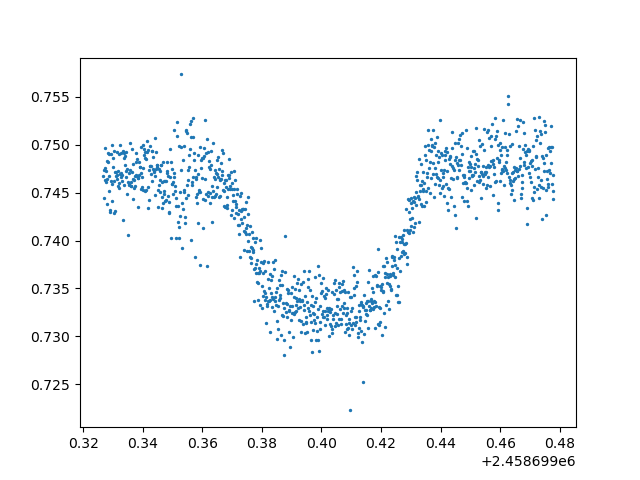

In [51]:
target_star = TemporaryAperturePhotometry()
target_star.aperture_photometry(13, 21, 8, 228, 33)
reference_star = TemporaryAperturePhotometry()
reference_star.aperture_photometry(13, 21, 8, 145, 20)

plt.figure()
plt.scatter(target_star.bjd_tdb, target_star.aperture/reference_star.aperture, s=2)
plt.show()